In [1]:
# Command to upload files
# I am uploading one month's worth of website events data for a cosmetics company
from google.colab import files
uploaded = files.upload()

Saving 2019-Dec.csv to 2019-Dec.csv


In [28]:
# Importing all libraries required for: data processing, linear regression, data visualization, matlab plotting, statistics, and date changes
import pandas as pd
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from IPython.display import display, Markdown, Latex
import plotly.express as px
import missingno as msno
from plotly import graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

In [67]:
# Assigning csv to a dataframe
import io
Shopping_Dec = pd.read_csv(io.BytesIO(uploaded['2019-Dec.csv']))

print("No of shopping events in Dec:" , len(Shopping_Dec))
print("Columns in events data:" , Shopping_Dec.columns)

No of shopping events in Dec: 3533286
Columns in events data: Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')


In [68]:
# Checking the numerical columns 
Shopping_Dec.describe()

,product_id,category_id,price,user_id
count,3.533286e+06,3.533286e+06,3.533286e+06,3.533286e+06
mean,5.473054e+06,1.555023e+18,8.871856e+00,5.223318e+08
std,1.331331e+06,1.689262e+17,1.986474e+01,8.494819e+07
min,3.752000e+03,1.487580e+18,-7.937000e+01,1.180452e+06
25%,5.726191e+06,1.487580e+18,2.060000e+00,4.866830e+08
50%,5.811429e+06,1.487580e+18,4.210000e+00,5.566496e+08
75%,5.859462e+06,1.487580e+18,7.140000e+00,5.828019e+08
max,5.917178e+06,2.235524e+18,3.277800e+02,5.954145e+08



*   All **ID columns** are **numerical**, so we may need to do a ***string conversion*** there to avoid issues down the line; we will decide this later if required during a step.
*   The **price** column seems to have some **incorrect** values: Min is **-79.37** which cannot be true. We will do further analysis here and ***clean*** this data.



In [69]:
# Calculating volume of shopping data so that we can understand scale for cleaning activities

Shopping_Dec["event_id"]= Shopping_Dec["event_time"].str.cat(Shopping_Dec["user_session"], sep ="-")
Shopping_Dec["event_id"].head()
print("No of unique events:" , len(Shopping_Dec['event_id'].unique().tolist()))
print("No of unique users:" , len(Shopping_Dec['user_id'].unique().tolist()))
print("No of unique sessions:" , len(Shopping_Dec['user_session'].unique().tolist()))

No of unique events: 3136227
No of unique users: 370154
No of unique sessions: 839813


In [70]:
# Now that we know the scale, we will check for volume of data with < 0 price and then decide on the appropriate action for cleaning

# We are grouping price < and > 0, to check the extent of the negative prices in the data, based on the min value shown in the describe table
Shopping_Dec.loc[Shopping_Dec.price < 0, 'price_lvl'] = 0
Shopping_Dec.loc[Shopping_Dec.price > 0, 'price_lvl'] = 1
 
# Now, performing counts based on this grouping to understand scale of issue
Shopping_Dec.groupby('price_lvl').count()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_id
price_lvl,,,,,,,,,,
0.0,18,18,18,18,0,0,18,18,18,18
1.0,3525679,3525679,3525679,3525679,58346,2022988,3525679,3525679,3524900,3524900


Since this is only **18 events**, we can ***drop*** these records

In [71]:
# Deleting records with prices less than 0 (Though these might be 'returns', since the event name doesn't explicitly mention this, we're deleting)
# Then dropping the column previously created for the price analysis
Shopping_Dec = Shopping_Dec[Shopping_Dec['price_lvl'] > 0]
Shopping_Dec.drop(["price_lvl"],axis=1,inplace=True)
len(Shopping_Dec)
Shopping_Dec.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'event_id'],
      dtype='object')

In [149]:
# Check for nulls
Shopping_Dec.isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    3467333
brand            1502691
price                  0
user_id                0
user_session         779
event_id             779
event_time_2           0
day                    0
date                   0
time                   0
hours                  0
weekday                0
weeknum                0
event_type_id          0
dtype: int64

In [152]:
# Of the above, I am not going to look at category or brand data.
# User session is important though, so I will clean values here
Shopping_Dec = Shopping_Dec.loc[Shopping_Dec['user_session'].notnull()]
len(Shopping_Dec)

3524900

In [72]:
# Checking data type of all columns in order to perform data type transformations if required
Shopping_Dec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525679 entries, 0 to 3533285
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
 9   event_id       object 
dtypes: float64(1), int64(3), object(6)
memory usage: 295.9+ MB


In [73]:
# Event_time is of data type object, which may cause issues with the analysis later
# So, we will create a second event_time column that takes event_time and converts it to pandas type

Shopping_Dec["event_time_2"] = pd.to_datetime(Shopping_Dec['event_time'])

# Now that this is converted, we will calculate certain time based attributes that could help with visualizations and analysis better 
Shopping_Dec['day'] = Shopping_Dec["event_time_2"].dt.day
Shopping_Dec["date"]=Shopping_Dec['event_time_2'].dt.date
Shopping_Dec["time"]=Shopping_Dec['event_time_2'].dt.time
Shopping_Dec["hours"]=Shopping_Dec['event_time_2'].dt.hour
Shopping_Dec["weekday"]=Shopping_Dec['event_time_2'].dt.weekday
Shopping_Dec['weeknum']=Shopping_Dec['event_time_2'].dt.isocalendar().week
Shopping_Dec.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_id,event_time_2,day,date,time,hours,weekday,weeknum
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019-12-01 00:00:00 UTC-51d85cb0-897f-48d2-918...,2019-12-01 00:00:00+00:00,1,2019-12-01,00:00:00,0,6,48
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019-12-01 00:00:00 UTC-8adff31e-2051-4894-975...,2019-12-01 00:00:00+00:00,1,2019-12-01,00:00:00,0,6,48
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019-12-01 00:00:02 UTC-c99a50e8-2fac-4c4d-89e...,2019-12-01 00:00:02+00:00,1,2019-12-01,00:00:02,0,6,48
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019-12-01 00:00:05 UTC-722ffea5-73c0-4924-8e8...,2019-12-01 00:00:05+00:00,1,2019-12-01,00:00:05,0,6,48
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12-01 00:00:07 UTC-28172809-7e4a-45ce-bab...,2019-12-01 00:00:07+00:00,1,2019-12-01,00:00:07,0,6,48


We will perform EDA based on the basis of time and events on the site, to guide us toward a marketing use case.

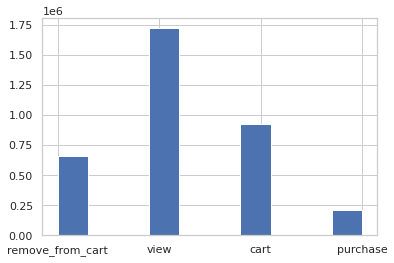

In [76]:
# Starting by understanding the distribution of events to inform further analysis
Shopping_Dec['event_type'].hist()

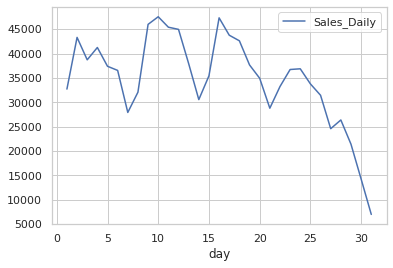

In [74]:
# Checking total sales revenue across all days of the month
Sale_per_day = Shopping_Dec[Shopping_Dec.event_type == "purchase"].groupby(['day'])['price'].agg(Sales_Daily = ('sum')).sort_values(by=['day'], ascending=True).plot.line()
Sale_per_day.set_ylabel = "Total Sales Daily"

It is surprising to observe the downward trend toward the end of the month, so we will be checking visitor count to see how they work together.

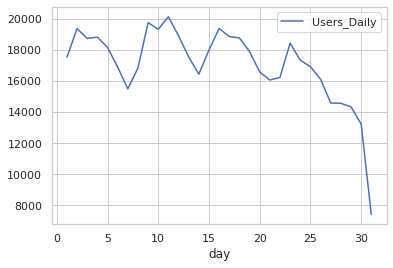

In [75]:
# Checking unique visitors across all days of the month
Visitors_per_day = Shopping_Dec.groupby(['day'])['user_id'].agg(Users_Daily =('nunique')).sort_values(by=['day'], ascending=True).plot.line()
Visitors_per_day.set_ylabel = "Visitors Daily"

In [77]:
# Giving order to the events for 
event_order = {'view':1, 'cart':2, 'purchase':4, 'remove_from_cart':3}
Shopping_Dec['event_type_id'] = Shopping_Dec['event_type'].map(event_order)
Shopping_Dec.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_id,event_time_2,day,date,time,hours,weekday,weeknum,event_type_id
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019-12-01 00:00:00 UTC-51d85cb0-897f-48d2-918...,2019-12-01 00:00:00+00:00,1,2019-12-01,00:00:00,0,6,48,3
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019-12-01 00:00:00 UTC-8adff31e-2051-4894-975...,2019-12-01 00:00:00+00:00,1,2019-12-01,00:00:00,0,6,48,1
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019-12-01 00:00:02 UTC-c99a50e8-2fac-4c4d-89e...,2019-12-01 00:00:02+00:00,1,2019-12-01,00:00:02,0,6,48,2
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019-12-01 00:00:05 UTC-722ffea5-73c0-4924-8e8...,2019-12-01 00:00:05+00:00,1,2019-12-01,00:00:05,0,6,48,1
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12-01 00:00:07 UTC-28172809-7e4a-45ce-bab...,2019-12-01 00:00:07+00:00,1,2019-12-01,00:00:07,0,6,48,1


([<matplotlib.axis.XTick at 0x7efc327306d0>,
 <a list of 4 Text major ticklabel objects>)

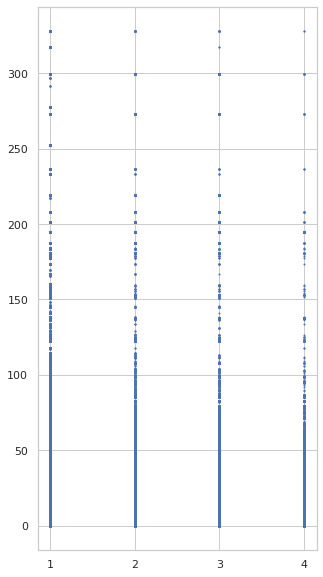

In [80]:
# With the ordering in place, now we can check out the distribution of prices across to see if that could've been a deciding factor
plt.figure(figsize=(5,10))
plt.scatter(Shopping_Dec['event_type_id'], Shopping_Dec['price'], s=1)
plt.xticks(np.arange(min(Shopping_Dec['event_type_id']), max(Shopping_Dec['event_type_id'])+1, 1.0))

From the above, we can see that from 1 > 2 > 4 (view > cart > purchase), the **high ticket value items are decreasing**. Similarly from 2 > 3 (cart > remove from cart), seems like some high price items may be removed.

In [84]:
# Now that we see patterns in price-to-event, visitors and purchase amount, 
# we want to have a collective view of purchase volume, purchase orders, and average order value across the days

# In here, we are calculating day-wise: total order value, number of orders, then using these to derive average order value
Sales_per_day_detailed = Shopping_Dec[Shopping_Dec['event_type']=='purchase'].groupby(['date'],as_index=False)['price'].sum()
Sales_per_day_detailed.columns=['date','total_order_value']
Sales_per_day_combined = Shopping_Dec[Shopping_Dec['event_type']=='purchase'].groupby(['date'],as_index=False)['price'].count()
Sales_per_day_combined.columns=['date','total_orders']
Sales_per_day_combined['avg_order_val'] = Sales_per_day_detailed['total_order_value']/Sales_per_day_combined['total_orders']


# Now, visualization this as a time series graph
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[1.0],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "Bar"}],
           [{"type": "Scatter"}]])

fig.add_trace(go.Bar(x=Sales_per_day_detailed['date'], y=Sales_per_day_detailed["total_order_value"],name='Total Order Value'),
             row=1,col=1)
fig.add_trace(go.Scatter(x=Sales_per_day_combined['date'], y=Sales_per_day_combined['total_orders'],
                    mode='lines+markers',
                    name='No of Orders'),
              row=1,col=1)
fig.add_trace(go.Scatter(x=Sales_per_day_combined['date'], y=Sales_per_day_combined['avg_order_val'],
                    mode='lines+markers',
                    name='Average Order Value'),
              row=2,col=1)
fig.update_layout(template='simple_white',     
                title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Sales Performance - Daily"}
                 )
fig.update_yaxes(title_text='Sales/No of Orders',ticks="inside", row=1)
fig.update_yaxes(title_text='Avg Order Val',ticks="inside", row=2)
fig.update_xaxes(title_text='Date',ticks="inside")
fig.show()


This shows something interesting - even as the **number of orders go down**, impacting the total order value, the **average order value goes up**. This is ***promising to explore*** from a marketing perspective, if we can bring in more users to buy during this period, the average order value is likely to be higher closer to the holiday season.

# Question 2: 

Looking at some of the data regarding purchases and dates, one question that seems worth answering is about **when to gear up the marketing and how**. 

To answer this, we may be looking at patterns within days, weeks, times of the day, and time taken to convert to guide us.

In [41]:
# To anwser the question of the timing of the marketing campaigns, step 1 is understanding buying behaviour 
# I am starting by trying to identify hour of the day and weeks where there are most number of web visitors. 
# I am counting unique visitors and not overall count 
hourly_visitors=Shopping_Dec.groupby(['hours','weeknum'],as_index=False)['user_id'].nunique()
hourly_visitors.columns=['hours','weeknum','user_id']

# Now, plotting the same into an Area chart, where the weeks form the areas
fig = px.area(hourly_visitors, x='hours', y="user_id",color='weeknum')
fig.update_layout(template='simple_white',     
                title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.4,
                         'text':"Hourly Website Views - Visitor Count"},
                xaxis = dict(
                    title_text='Hour of the day',
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 3),
                 yaxis = dict(
                    title_text='Visitors'))
fig.show()

From the above visualization, we can see that 
*   Overall, the total visitors keep growing per week throughout December, peaking in the last week
*   Additionally, most visits during the week happen between 6 AM - 9 PM, with the peaks at 12 PM and 7 PM (potentially lunch hours and pre-prime time / post office hours). 
*   After 7 PM, it steadily goes down, potentially as family and / or entertainment become more active

# Recommendations

*   **Increase marketing spends** from Week 1 to Week 4 in December gradually, to ensure that ***last minute shoppers*** choose this cosmetics website over the others
*   **Stagger promotional offers** across these weeks to offer the maximum discounts toward ***weeks 3 and 4*** (51 and 52)
*   Show more ads (search, display, video etc) and marketing offers (promo emails, push notifications etc) in these time windows: **10 AM - 1 PM** and **5 PM - 7 PM** when users are most active









In [89]:
# Next, we want to explore general patterns of browsing behavior across events - from view to purchase - in order to decide a strategy for retargeting
# Since user sessions are unique IDs, using that to partition, and sorting by the data formatted timestamp field
order_of_events = Shopping_Dec.sort_values(['event_time_2'],ascending=True).groupby('user_session')['event_type'].apply(list).to_frame(name='sequences')

# Mark the 'drop off' by appending 'drop' to the end of the sequence
order_of_events['sequences'] = order_of_events.apply(lambda x: x['sequences'] + ['drop'], axis=1)

# To compare sequences of 'purchase' complete users from 'cart remove' users, adding filters to copy into different data frames

# Keep only sequences with at least one purchase
ordered_events_purchase = order_of_events[order_of_events.sequences.apply(lambda x: np.any(np.in1d(x, ['purchase'])))]
ordered_events_removecart = order_of_events[order_of_events.sequences.apply(lambda x: np.any(np.in1d(x, ['remove_from_cart'])))]

ordered_events_purchase.head()

# In order to get counts against sequences, converting the array to a string
ordered_events_purchase['sequences'] = ['-'.join(map(str, l)) for l in ordered_events_purchase['sequences']]
ordered_events_removecart['sequences'] = ['-'.join(map(str, l)) for l in ordered_events_removecart['sequences']]

# Seeing the sequences that are most repeated across 
Top_purchase_sequences = ordered_events_purchase['sequences'].value_counts().nlargest(100).to_frame(name='Purchase_Occurences')
Top_removecart_sequences = ordered_events_removecart['sequences'].value_counts().nlargest(100).to_frame(name='Removecart_Occurences')

print(Top_purchase_sequences)
print(Top_removecart_sequences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                                                    Purchase_Occurences
view-cart-purchase-drop                                             508
purchase-purchase-purchase-drop                                     328
purchase-purchase-drop                                              322
purchase-purchase-purchase-purchase-drop                            285
purchase-drop                                                       267
...                                                                 ...
view-view-cart-cart-purchase-purchase-drop                           17
remove_from_cart-purchase-purchase-purchase-pur...                   17
view-cart-cart-cart-remove_from_cart-remove_fro...                   16
view-cart-remove_from_cart-purchase-purchase-pu...                   16
view-view-purchase-drop                                              16

[100 rows x 1 columns]
                                                    Removecart_Occurences
remove_from_cart-remove_from_cart-drop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



From this list, it seems like most people who **remove from cart** tend to drop off and **not purchase** after. This makes them a critical segment to focus on, given that they are already up the funnel by adding items to cart.

# Recommendations
*   For the retargeting campaign, we will focus a **higher amount of budget** on people who **remove items** from cart and then **directly drop off** without browsing around
*   People who **complete purchase** have a high occurence of multiple sequential purchases, which means **>1 item added** to the order. This means, for the 'remove cart' segment, **specific focus** should be on people who have **>1 item in their cart**, because they are likely to purchase.




In [92]:
Shopping_Dec['weekday'].unique().tolist()

[6, 0, 1, 2, 3, 4, 5]

In [125]:
# We can explore weekday vs weekend to identify opportunities to best reach out to customers

# In EDA, we calculated number of daily visitors
# Visitors_per_day = Shopping_Dec.groupby(['day'])['user_id'].agg(Users_Daily =('nunique')).sort_values(by=['day'], ascending=True).plot.line()

# Since weekday starts from 0 and ends at 6, marking 5,6 as weekend and rest as weekday
#pd_df.set_index('Date', inplace=True, drop=True)
df_weekend = Shopping_Dec.copy()
df_weekend.set_index('date', inplace=True)
df_weekend = df_weekend[df_weekend.weekday>4]
df_weekday = Shopping_Dec.copy()
df_weekday.set_index('date', inplace=True)
df_weekday = df_weekday[df_weekday.weekday<=4]
#df_weekday
#df_weekday['date'].unique().tolist()


# Create distinct dataframes
visitors_weekend = df_weekend.groupby('weekday')['user_id'].nunique()
visitors_weekday = df_weekday.groupby('weekday')['user_id'].nunique()

# Plot on graph to visualize

fig = go.Figure()
fig.add_trace(go.Scatter(
            x=visitors_weekend.index.tolist(), y=visitors_weekend.values.tolist(),mode="lines+markers", name="Weekends",marker=dict(size=visitors_weekend.values//1500)))
fig.add_trace(go.Scatter(
            x=visitors_weekday.index.tolist(), y=visitors_weekday.values.tolist(),mode="markers",name="Weekdays",marker=dict(size=visitors_weekday.values//1500)))
fig.update_layout(title="Daily visits as per Day-of-Week", xaxis_title="December",yaxis_title="Frequency")
fig.show()





Visits to the website spike during Sun-Mon period, with Monday being the period with the highest visits. 
Another interesting observation is how the trend shows a waning interest throughout the week, only to spike after Saturday.

# Recommendation:
Contrary to conventional marketing wisdom, **weekends** as a whole **aren't very fruitful** for this website. So more efforts should be concentrated during **Sunday** and **Monday**, with weekday efforts restricted to the time windows identified in the previous analysis.

In [137]:
# Checking for high order value based on hours
order_val_date_hr=Shopping_Dec[Shopping_Dec['event_type']=='purchase'].groupby(['date','hours'],as_index=False)['price'].sum()
order_val_date_hr.columns=['date','hours','order_val']
order_val_date_hr['hours']=order_val_date_hr['hours'].astype(str)
order_val_date_hr['date']=order_val_date_hr['date'].astype(str)

fig = make_subplots(
    rows=2, cols=1,
    column_widths=[1.0],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "histogram2d"}],
           [{"type": "histogram2dcontour"}]])
fig.add_trace(
    go.Histogram2d(
        x = order_val_date_hr["date"],
        y = order_val_date_hr["hours"],
        z = order_val_date_hr["order_val"],
        colorbar=dict(len=0.5, y=0.8,title="Total Order Value"),
        histfunc = "sum",
        colorscale = "Electric",
        nbinsx = 31,
        nbinsy=24),
    row=1,col=1)
fig.add_trace(
    go.Histogram2dContour(
        x = order_val_date_hr["date"],
        y = order_val_date_hr["hours"],
        z = order_val_date_hr["order_val"],
        colorbar=dict(len=0.5, y=0.25,title="Total Order Value",tickmode="array",
        tickvals=[20000,40000,60000,80000,100000,120000],),
        histfunc = "sum",
        showlegend=False,
        colorscale = "Electric",
        contours = dict(
            showlabels = True),
        nbinsx=31,
        nbinsy=24),
    row=2,col=1)


fig.update_layout(
    template="simple_white",
    margin=dict(r=50, t=50, b=50, l=50),
    height=600,
    showlegend=False,
    title={'xanchor': 'center',
           'yanchor': 'top',        
            'y':1,
            'x':0.5,
           'text':"Hourly sales during December"}
)
fig.update_yaxes(title_text='Hours',ticks="inside")
fig.update_xaxes(title_text='Date',ticks="inside")
fig.show()

High order values seem to happen during the afternoon predominantly, potentially due to the 'activeness' required from the user to complete such purchases.

# Recommendation:
In the ads shown in the ***afternoon***, push for **high price products** and **high value categories** from the product catalogue.

In [148]:
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[1.0],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "histogram2d"}],
           [{"type": "histogram2dcontour"}]])
fig.add_trace(
    go.Histogram2d(
        x = hourly_visitors["hours"],
        y = hourly_visitors["weeknum"],
        z = hourly_visitors["user_id"],
        colorbar=dict(len=0.5, y=0.8,title="Total Order Value"),
        histfunc = "sum",
        colorscale='Hot',
        nbinsx = 31,
        nbinsy=7
    ),
    row=1,col=1)
fig.add_trace(
    go.Histogram2dContour(
        x = hourly_visitors["hours"],
        y = hourly_visitors["weeknum"],
        z = hourly_visitors["user_id"],
        colorbar=dict(len=0.5, y=0.20,title="Total Order Value",tickmode="array"
                     ),
        histfunc = "sum",
        showlegend=False,
        colorscale='Hot',
        contours = dict(
            showlabels = True),
        nbinsx=31,
        nbinsy=7
    ),
    row=2,col=1)


fig.update_layout(
    template="simple_white",
    margin=dict(r=50, t=50, b=50, l=50),
    height=600,
    showlegend=False,
    title={'xanchor': 'center',
           'yanchor': 'top',        
            'y':0.999,
            'x':0.5,
           'text':"Hourly sales by Week-of-month"}
)
fig.update_yaxes(title_text='Week-of-Month',ticks="inside")
fig.update_xaxes(title_text='Hours',ticks="inside")
fig.show()

The highest order values have happened toward the last weeks of December.
During this time, the highes order values are placed between ***8 AM - 12 PM***, and later between ***4 PM - 8 PM***.

# Recommendation:
* From this, we will ramp up the marketing activities **just before Christmas**, with special emphasis on the times shown with the highest order value.
* Our product **recommendations** in this time will be **more varied**, in order to attract and maximise the items purchased.